In [2]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns



### Explanation of Feature Extraction Parameters:


#### **`sr = 16000` (Sampling Rate)**  
We use a 16 kHz sampling rate because:  
- It is standard for speech processing tasks (also used in datasets like CREMA-D and others).  
- Human speech rarely contains important frequency content above 8 kHz, and by Nyquist's theorem, a 16 kHz sampling rate fully captures this without unnecessary data overhead.  
- It reduces computational load compared to 44.1 kHz or 48 kHz sampling without losing essential speech detail.  

---

#### **`n_fft = 512` (FFT window size)**  
- With `sr = 16000`, an `n_fft = 512` corresponds to a **32 ms window** (512 / 16000 = 0.032s).  
- A 32 ms window is an excellent choice because:  
  - It is long enough to capture steady-state speech characteristics like formants and stable spectral properties.  
  - It still allows reasonable time resolution to capture dynamic transitions in emotion (like sudden energy changes or articulation shifts).  
- Larger FFT windows (e.g., 1024) can smooth out short-term changes, making dynamic emotions harder to detect.  
- Smaller FFT windows (< 512) may cause frequency resolution loss.  


---

#### **`hop_length = 205` (frame step)**  
- With `sr = 16000` and `hop_length = 205`, each step is approximately **12.8 ms**.  
- This results in roughly **60% overlap** between consecutive windows (since 205 is about 40% of 512).  
- Why 60% overlap?  
  - Higher overlap ensures that no sudden changes (especially in emotional speech transitions) are missed between frames.  
  - It smooths the temporal progression of features, allowing better tracking of continuous changes in speech energy, pitch, and articulation.  
- Lower overlaps (e.g., 25%) can make transitions more "jumpy" and lose smoothness, while extremely high overlaps increase computation without significant additional benefit.


---

#### **`n_mfcc = 13` (Number of MFCC coefficients)**  
- **13 MFCC coefficients** is the classical standard for speech processing tasks.  
- These coefficients capture the shape of the vocal tract well and have been validated in both emotion and speech recognition tasks.  
- Fewer coefficients (< 13) risk losing resolution of vocal features.  
- More than 13 coefficients can start capturing noise and speaker-specific idiosyncrasies rather than emotion-relevant phonetic features.  


---


In [7]:
# === CONFIGURATION ===
#preprocessed_dataset_path = r"F:\PreProcessedDataSet_for_ML"
preprocessed_dataset_path = r"C:\Users\Mahmodiyan-PC\Desktop\agha alborz\term6\datascience\final project\PreProcessedDataSet_for_ML"
csv_features_path = r"F:\csv_features\audio_features.csv"
csv_aggregated_features_path = r"F:\csv_features\audio_aggregated_features.csv"
N_FFT = 512 # 32 ms window 
HOP_LENGTH = 205 # 12.8 ms step → 60% overlap
SR=16000 
N_MFCC=13 


### Explanation of Feature Selection and Parameter Choices for Speech Emotion Recognition (CREMA-D Dataset)

#### MFCC (Mel-Frequency Cepstral Coefficients)

**What is it?**  
MFCCs represent the short-term power spectrum of speech signals based on human auditory perception (the mel scale). They capture the shape and configuration of the vocal tract, which changes with articulation.

**Why do we use MFCC?**  
The articulation patterns of speech are strongly influenced by emotion. For example, anger and excitement cause tense, sharp articulation; sadness leads to soft, dull speech. MFCCs help model these articulatory characteristics effectively.

**Why use 13 coefficients?**  
Thirteen coefficients strike a well-established balance:  
- Fewer than 13 coefficients can underrepresent the spectrum’s important details.  
- More than 13 may start to capture irrelevant noise or speaker identity traits rather than emotion-related changes.

**Why keep both mean and standard deviation?**  
The mean MFCC vector captures the average shape of the vocal tract across the utterance. The standard deviation highlights how much the articulation changes during the utterance. Emotional speech tends to be more dynamic (e.g., sudden shifts in anger or excitement), and the std helps measure this variability.

---

#### MFCC Delta and Delta-Delta

**What are they?**  
These are the first and second-order time derivatives of the MFCC coefficients, capturing the velocity and acceleration of feature changes across frames.

**Why do we use delta and delta-delta?**  
While static MFCCs represent the spectral shape, deltas and delta-deltas capture dynamic changes in articulation, which are highly emotion-dependent. For instance, sudden changes in pitch or formants are characteristic of certain emotions.

**Why keep both mean and standard deviation?**  
The mean captures the overall direction and smoothness of changes. The standard deviation measures how stable or abrupt these dynamic transitions are. Emotions like anger or surprise often show greater fluctuations, reflected well in the std.

---

#### Zero Crossing Rate (ZCR)

**What is it?**  
ZCR is the rate at which the signal waveform crosses the zero amplitude axis. It indirectly measures the noisiness and frequency content of the speech.

**Why do we use ZCR?**  
Energetic or tense emotions (like anger or excitement) often involve more fricatives and sharper sounds, leading to higher zero crossing rates. Calm or sad speech tends to have lower ZCR.

**Why the chosen parameters?**  
We use the same frame length (`n_fft=1024`) and `hop_length=512` as for MFCCs to maintain alignment across all features and ensure consistent temporal resolution.

**Why keep both mean and standard deviation?**  
The mean ZCR gives a stable measurement of the overall noisiness or articulation sharpness. The standard deviation helps capture frame-to-frame variability, which can differentiate between calm (steady) and agitated (fluctuating) speech.

---

#### RMS Energy

**What is it?**  
RMS (Root Mean Square) energy measures the loudness of the audio signal.

**Why do we use RMS energy?**  
Emotional states heavily influence speech energy. For example, anger, happiness, and fear often result in louder, more energetic speech; sadness and boredom lower energy levels.

**Why use consistent frame analysis parameters?**  
By using `n_fft=1024` and `hop_length=512`, we align RMS measurement with other time-based features for coherence.

**Why keep both mean and standard deviation?**  
The mean energy indicates the general loudness level. The standard deviation reflects fluctuations in loudness across frames, which is key for capturing dynamic emotional expressions like sudden bursts of energy in anger or excitement.

---

#### Spectral Centroid

**What is it?**  
The spectral centroid measures the center of mass of the spectrum, indicating where most energy is concentrated in the frequency domain.

**Why do we use spectral centroid?**  
Brighter (higher centroid) signals are associated with energetic or excited emotions, while darker (lower centroid) signals indicate sadness or calmness.

**Why use only the mean?**  
Centroid values are generally stable within short utterances, and their average conveys enough discriminative power. Variance often adds noise rather than informative emotional cues, especially in clean recordings.

---

#### Spectral Bandwidth

**What is it?**  
Spectral bandwidth represents the spread of frequencies around the centroid.

**Why do we use spectral bandwidth?**  
A wider bandwidth indicates more tension and higher-frequency activity (typical in anger and excitement). Narrow bandwidth corresponds to calmer, more monotone speech.

**Why use only the mean?**  
Like the centroid, bandwidth is a relatively stable descriptor. The mean effectively captures this feature; standard deviation does not contribute meaningfully for short emotional utterances.

---

#### Spectral Rolloff

**What is it?**  
Spectral rolloff is the frequency below which a certain percentage (typically 85%) of the spectral energy lies.

**Why do we use spectral rolloff?**  
Higher rolloff values suggest more high-frequency energy, often found in tense, excited, or angry speech. Lower rolloff values are associated with soft, smooth speech, characteristic of sadness.

**Why use only the mean?**  
The rolloff tends to remain stable across frames. Variance often represents measurement noise rather than emotion-driven changes.

---

#### Spectral Contrast

**What is it?**  
Spectral contrast measures the difference between peaks and valleys in the spectral envelope, computed across frequency sub-bands.

**Why do we use spectral contrast?**  
Emotionally expressive speech (anger, excitement) exhibits stronger contrast between prominent frequencies and valleys. Monotone speech (sadness) shows lower contrast.

**Why keep both mean and standard deviation?**  
The mean contrast indicates the overall dynamic range, while the standard deviation reveals frame-to-frame articulation dynamics. Emotional fluctuations are often well captured through std.

---

#### Chroma Features

**What are they?**  
Chroma features map the energy distribution into 12 pitch classes (like musical notes), offering a compact representation of pitch-based information.

**Why do we use chroma features?**  
Although speech is not melodic, emotional intonation shifts can cause systematic changes in pitch distribution. Emotions like excitement or happiness might emphasize certain pitch ranges, while sadness flattens pitch variation.

**Why use only the mean?**  
The mean chroma vector effectively captures the overall pitch class distribution. The standard deviation of chroma features typically adds little value for emotional analysis and can introduce redundancy or noise.

---


In [38]:
# =================== FEATURE EXCTRACTION FUNCTIONS WE USED ===================
def compute_mfcc(y, sr, n_mfcc, n_fft, hop_length):

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc

    # mfcc_mean = mfcc.mean(axis=1)
    # mfcc_std = mfcc.std(axis=1)
    
    # mfcc_delta = librosa.feature.delta(mfcc, order=1)
    # delta_mean = mfcc_delta.mean(axis=1)
    # delta_std = mfcc_delta.std(axis=1)
    
    # mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    # delta2_mean = mfcc_delta2.mean(axis=1)
    # delta2_std = mfcc_delta2.std(axis=1)

    # print(mfcc.shape)
    
    # return (mfcc_mean, mfcc_std, 
    #         delta_mean, delta_std,
    #         delta2_mean, delta2_std)

def compute_zcr(y, n_fft, hop_length):
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)
    return zcr

def compute_rms(y, n_fft, hop_length):
    rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    return rms

def compute_centroid(y, sr, n_fft, hop_length):
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return centroid

def compute_bandwidth(y, sr, n_fft, hop_length):
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return bandwidth

def compute_rolloff(y, sr, n_fft, hop_length):
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return rolloff

def compute_spectral_contrast(y, sr, n_fft, hop_length):
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return spectral_contrast

def compute_chroma(y, sr, n_fft, hop_length):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return chroma

def compute_spectral_flux(y, sr, n_fft, hop_length):
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    flux = np.sqrt(np.sum(np.diff(S, axis=1)**2, axis=0))
    return flux


In [39]:
def extract_features_from_audio(file_path):
    try:
        y, _ = librosa.load(file_path, sr=SR)
        
        # MFCCs, MFCC Delta & Delta-Delta
        mfcc = compute_mfcc(y, SR, N_MFCC, N_FFT, HOP_LENGTH)

        # Zero Crossing Rate
        zcr = compute_zcr(y, N_FFT, HOP_LENGTH)

        # RMS Energy
        rms = compute_rms(y, N_FFT, HOP_LENGTH)

        # Spectral Features (only mean)
        centroid = compute_centroid(y, SR, N_FFT, HOP_LENGTH)
        bandwidth = compute_bandwidth(y, SR, N_FFT, HOP_LENGTH)
        rolloff = compute_rolloff(y, SR, N_FFT, HOP_LENGTH)

        # Spectral Contrast (mean + std)
        contrast = compute_spectral_contrast(y, SR, N_FFT, HOP_LENGTH)

        # Chroma Features (mean only)
        chroma = compute_chroma(y, SR, N_FFT, HOP_LENGTH)
        features = np.concatenate((
            mfcc, zcr, rms, centroid, bandwidth, rolloff, contrast, chroma
        ), axis=0)

        aggregated_features = np.concatenate((
            mfcc.mean(axis=1),  # Mean across the time axis for MFCC
            [zcr.mean()],  # Mean of Zero Crossing Rate
            [rms.mean()],  # Mean of RMS Energy
            [centroid.mean()],  # Mean of Spectral Centroid
            [bandwidth.mean()],  # Mean of Spectral Bandwidth
            [rolloff.mean()],  # Mean of Spectral Roll-off
            contrast.mean(axis=1),  # Mean across the time axis for Spectral Contrast
            chroma.mean(axis=1)  # Mean across the time axis for Chroma
        ))

        return features, aggregated_features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    

Here’s a clean, brief, and professional explanation of why each of these features was **not used** in your final extraction pipeline:  

---

### Why These Features Were Not Included:

#### 1. **Spectral Flatness**  
- **What it is:** Measures how noise-like or tone-like the signal is.  
- **Why not used:**  
  - It’s highly correlated with spectral contrast and ZCR, which we already use.  
  - Adding it would introduce redundancy rather than new information, increasing feature dimensionality unnecessarily.  

---

#### 2. **Tonnetz (Tonal Centroid Features)**  
- **What it is:** Measures harmonic relations and pitch stability, mainly used in music.  
- **Why not used:**  
  - Emotional speech rarely follows harmonic structures like music.  
  - This feature is not robust for short, non-musical utterances and may introduce noise into the feature set.  

---

#### 3. **Spectral Polynomial Coefficients**  
- **What it is:** Polynomial approximation of spectral shape.  
- **Why not used:**  
  - This feature is rarely used in speech emotion recognition research.  
  - It is often unstable, version-dependent in `librosa`, and lacks literature support for SER.  
  - Risk of overfitting without proven benefit.  

---

#### 4. **Tempogram (tempo variation)**  
- **What it is:** Describes tempo fluctuations based on onset strength.  
- **Why not used:**  
  - Emotional speech does not have strong rhythmic structures like music.  
  - Utterances in CREMA-D are short and don't show tempo variations that would meaningfully correlate with emotion.  

---

#### 5. **F0 (Pitch) Estimation**  
- **What it is:** Average pitch estimation from `pyin`.  
- **Why not used:**  
  - While pitch is emotionally relevant, `pyin` can be computationally heavy and unstable for noisy or short utterances.  
  - RMS, spectral centroid, and MFCC deltas already capture pitch and energy dynamics indirectly but more robustly.  

---

#### 6. **HNR (Harmonic-to-Noise Ratio)**  
- **What it is:** Ratio of periodic (harmonic) to noise components.  
- **Why not used:**  
  - Requires external libraries (Parselmouth), adding complexity and slowdowns.  
  - In short speech samples, HNR estimates can be unreliable, and we already capture related information through spectral contrast and ZCR.  

---


In [40]:
# # Spectral Flatness (mean & std)
# def compute_spectral_flatness(y, n_fft=1024, hop_length=512):
#     flatness = librosa.feature.spectral_flatness(y=y, n_fft=n_fft, hop_length=hop_length)
#     flatness_mean = flatness.mean()
#     flatness_std = flatness.std()
#     return flatness_mean, flatness_std

# # Tonnetz (Tonal Centroid Features)
# def compute_tonnetz(y, sr=16000):
#     y_harmonic = librosa.effects.harmonic(y)
#     tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
#     tonnetz_mean = tonnetz.mean(axis=1)
#     tonnetz_std = tonnetz.std(axis=1)
#     return tonnetz_mean, tonnetz_std

# # Spectral Polynomial Coefficients (if supported by your librosa version)
# def compute_spectral_poly(y, sr=16000, n_fft=1024, hop_length=512, order=2):
#     try:
#         spec_poly = librosa.feature.spectral_polynomial(y=y, sr=sr, order=order, n_fft=n_fft, hop_length=hop_length)
#         spec_poly_mean = spec_poly.mean(axis=1)
#         spec_poly_std = spec_poly.std(axis=1)
#         return spec_poly_mean, spec_poly_std
#     except AttributeError:
#         print("spectral_polynomial not available in this librosa version.")
#         return np.array([]), np.array([])

# # Tempogram (tempo variation features)
# def compute_tempogram(y, sr=16000, hop_length=512):
#     onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
#     tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
#     tempogram_mean = tempogram.mean(axis=1)
#     tempogram_std = tempogram.std(axis=1)
#     return tempogram_mean, tempogram_std

# # F0 (Pitch) Estimation using librosa.pyin
# def compute_pitch(y, sr=16000):
#     f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
#     f0_nonan = f0[~np.isnan(f0)]
#     if len(f0_nonan) == 0:
#         return 0.0, 0.0
#     f0_mean = np.mean(f0_nonan)
#     f0_std = np.std(f0_nonan)
#     return f0_mean, f0_std

# # Harmonic-to-Noise Ratio (HNR)
# import parselmouth
# def compute_hnr(y, sr=16000):
#     try:
#         sound = parselmouth.Sound(y, sampling_frequency=sr)
#         pointProcess = sound.to_point_process_cc()
#         hnr_values = sound.to_harmonicity_ac().values.T
#         hnr_nonan = hnr_values[~np.isnan(hnr_values)]
#         if len(hnr_nonan) == 0:
#             return 0.0, 0.0
#         hnr_mean = np.mean(hnr_nonan)
#         hnr_std = np.std(hnr_nonan)
#         return hnr_mean, hnr_std
#     except Exception as e:
#         print(f"Error computing HNR: {e}")
#         return 0.0, 0.0


Main pipeLine so that each audio gets its features extracted!

In [41]:
features = []
aggregated_features = []
filenames = []
emotions = []

for file in os.listdir(preprocessed_dataset_path):
    if file.lower().endswith(".wav"):
        path = os.path.join(preprocessed_dataset_path, file)
        result, aggregated_result = extract_features_from_audio(path)
        if result is not None and aggregated_result is not None:
            parts = file.split('_')
            emotion = parts[2]
            print(f"features are extracted from : {file}")
            feature_vector = [list(feature) for feature in result]
            features.append(feature_vector)
            aggregated_features.append(aggregated_result)
            filenames.append(file)
            emotions.append(emotion)

# print("Number of audio files:", len(features))
# print("Number of features per file:", len(features[0])) 
# print("Number of frames per feature:", len(features[0][0])) 

# Feature column names
mfcc_cols = [f"mfcc{i+1}" for i in range(13)]

spec_cols = [
    "zcr",
    "rms",
    "centroid",
    "bandwidth",
    "rolloff"
]

contrast_cols = [f"spectral_contrast_band{i+1}" for i in range(7)] 

chroma_cols = [f"chroma{i+1}" for i in range(12)]

columns = ["file_name"] + mfcc_cols + spec_cols + contrast_cols + chroma_cols + ["emotion"]

encoder = LabelEncoder()
encoded_emotions = encoder.fit_transform(emotions)

# df = pd.DataFrame(features, columns=mfcc_cols + spec_cols + contrast_cols + chroma_cols)
# df.insert(0, "file_name", filenames)
# df['emotion'] = encoded_emotions
# df.to_csv(csv_features_path, index=False)

df_aggregated = pd.DataFrame(aggregated_features, columns=mfcc_cols + spec_cols + contrast_cols + chroma_cols)
df_aggregated.insert(0, "file_name", filenames)
df_aggregated['emotion'] = encoded_emotions
df_aggregated.to_csv(csv_aggregated_features_path, index=False)

features are extracted from : 1001_DFA_ANG_XX.wav_chunk1.wav
features are extracted from : 1001_DFA_ANG_XX.wav_chunk2.wav
features are extracted from : 1001_DFA_DIS_XX.wav_chunk1.wav
features are extracted from : 1001_DFA_DIS_XX.wav_chunk2.wav
features are extracted from : 1001_DFA_FEA_XX.wav_chunk1.wav
features are extracted from : 1001_DFA_HAP_XX.wav_chunk1.wav
features are extracted from : 1001_DFA_HAP_XX.wav_chunk2.wav
features are extracted from : 1001_DFA_NEU_XX.wav_chunk1.wav
features are extracted from : 1001_DFA_NEU_XX.wav_chunk2.wav
features are extracted from : 1001_DFA_SAD_XX.wav_chunk1.wav
features are extracted from : 1001_DFA_SAD_XX.wav_chunk2.wav
features are extracted from : 1001_DFA_SAD_XX.wav_chunk3.wav
features are extracted from : 1001_IEO_ANG_HI.wav_chunk1.wav
features are extracted from : 1001_IEO_ANG_HI.wav_chunk2.wav
features are extracted from : 1001_IEO_ANG_LO.wav_chunk1.wav
features are extracted from : 1001_IEO_ANG_MD.wav_chunk1.wav
features are extracted f

In [ ]:
df = pd.read_csv(csv_aggregated_features_path)

# Define features and target
X = df.iloc[:, 1:-1]  # Features: all columns except first (filename) and last (target)
y = df.iloc[:, -1]    # Target: last column

# Compute Mutual Information
mutual_info = mutual_info_classif(X, y)

# Compute Correlation (Pearson)
correlations = X.corrwith(y)

# Combine into a single DataFrame
mi_corr_df = pd.DataFrame({
    "Mutual Information": mutual_info,
    "Correlation": correlations
})

print(mi_corr_df)
mi_corr_df.to_csv("Analytics/mi_corr_aggregated_features.csv", index=False)

In [ ]:
df = pd.read_csv(csv_features_path)

feature_columns = df.columns[1:-1]
results = []

# Loop through each feature
for feature_name in feature_columns:
    # Parse the list into 2D array
    feature_series = df[feature_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    X = np.stack(feature_series.values)

    # Create frame-wise DataFrame
    frame_df = pd.DataFrame(X, columns=[f"{feature_name}_frame_{i}" for i in range(X.shape[1])])

    # Pearson correlation
    corr = frame_df.corrwith(y)

    # Mutual information
    mi = mutual_info_classif(frame_df, y, discrete_features=False)

    # Combine into result list
    for i in range(X.shape[1]):
        results.append({
            "Feature": feature_name,
            "Frame": i,
            "Frame_Name": f"{feature_name}_frame_{i}",
            "Correlation": corr.iloc[i],
            "Mutual Information": mi[i]
        })

# Combine into a single DataFrame
mi_corr_df = pd.DataFrame(results)

# Preview result
print(mi_corr_df.head())
mi_corr_df.to_csv("Analytics/framewise_mi_corr_all_features.csv", index=False)

In [4]:
import ast
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your feature CSV again
df = pd.read_csv(csv_features_path, nrows = 15000)  # replace with actual path if needed

# Define the plotting function
def plot_pca_for_feature(df_column, feature_name):
    feature_series = df_column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    X = np.stack(feature_series.values)
    
    pca = PCA()
    pca.fit(X)
    explained = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6, 4))
    plt.plot(explained, marker='o')
    plt.title(f"PCA - Cumulative Variance for {feature_name}")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Explained")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Feature column names
mfcc_cols = [f"mfcc{i+1}" for i in range(13)]
spec_cols = ["zcr", "rms", "centroid", "bandwidth", "rolloff"]
contrast_cols = [f"spectral_contrast_band{i+1}" for i in range(7)]
chroma_cols = [f"chroma{i+1}" for i in range(12)]

all_feature_names = mfcc_cols + spec_cols + contrast_cols + chroma_cols

# Loop and plot PCA for each feature column
for feature_name in all_feature_names:
    print(f"Running PCA on: {feature_name}")
    # plot_pca_for_feature(df[feature_name], feature_name)


Running PCA on: mfcc1
Running PCA on: mfcc2
Running PCA on: mfcc3
Running PCA on: mfcc4
Running PCA on: mfcc5
Running PCA on: mfcc6
Running PCA on: mfcc7
Running PCA on: mfcc8
Running PCA on: mfcc9
Running PCA on: mfcc10
Running PCA on: mfcc11
Running PCA on: mfcc12
Running PCA on: mfcc13
Running PCA on: zcr
Running PCA on: rms
Running PCA on: centroid
Running PCA on: bandwidth
Running PCA on: rolloff
Running PCA on: spectral_contrast_band1
Running PCA on: spectral_contrast_band2
Running PCA on: spectral_contrast_band3
Running PCA on: spectral_contrast_band4
Running PCA on: spectral_contrast_band5
Running PCA on: spectral_contrast_band6
Running PCA on: spectral_contrast_band7
Running PCA on: chroma1
Running PCA on: chroma2
Running PCA on: chroma3
Running PCA on: chroma4
Running PCA on: chroma5
Running PCA on: chroma6
Running PCA on: chroma7
Running PCA on: chroma8
Running PCA on: chroma9
Running PCA on: chroma10
Running PCA on: chroma11
Running PCA on: chroma12


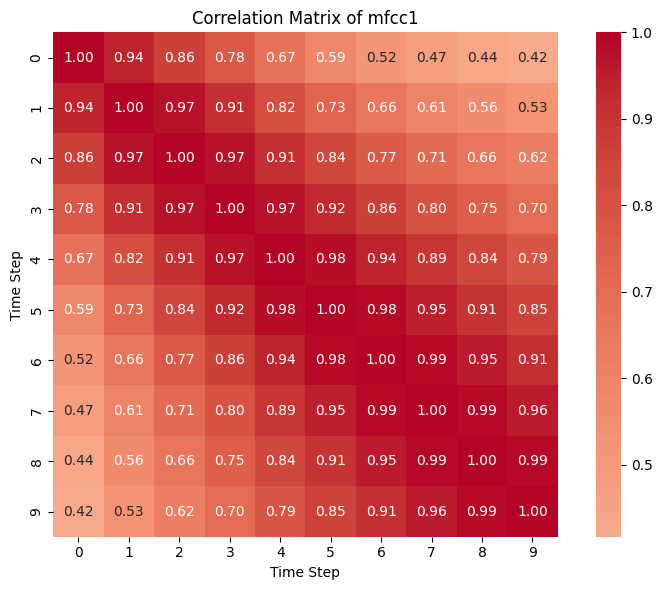

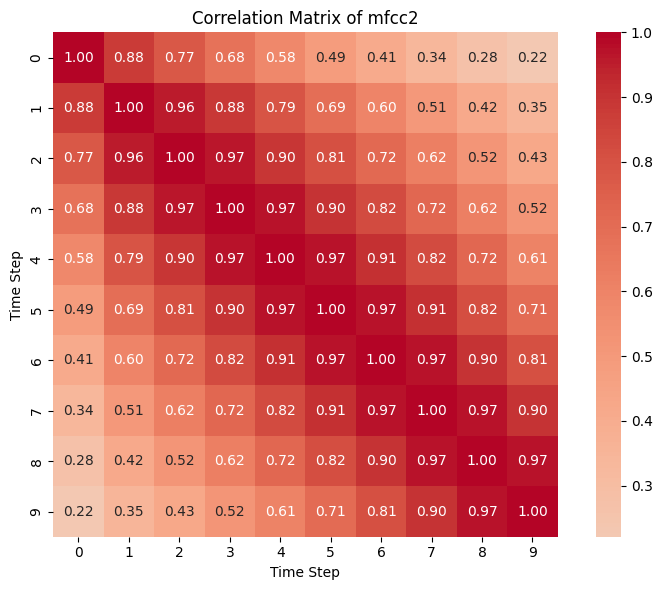

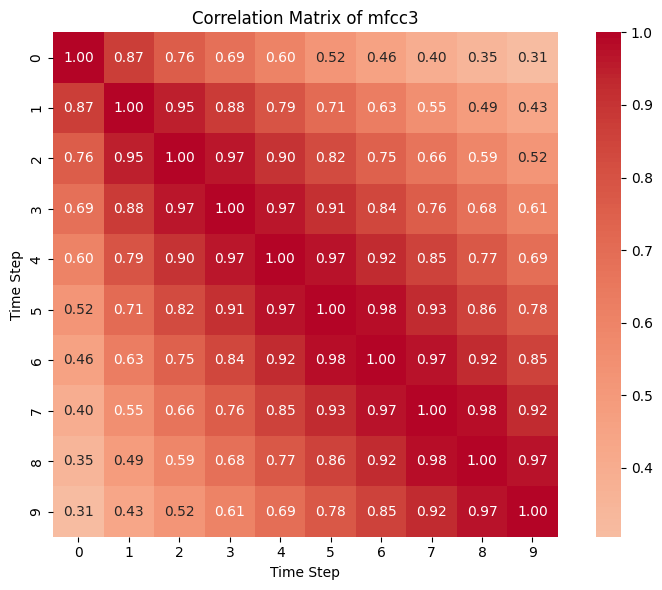

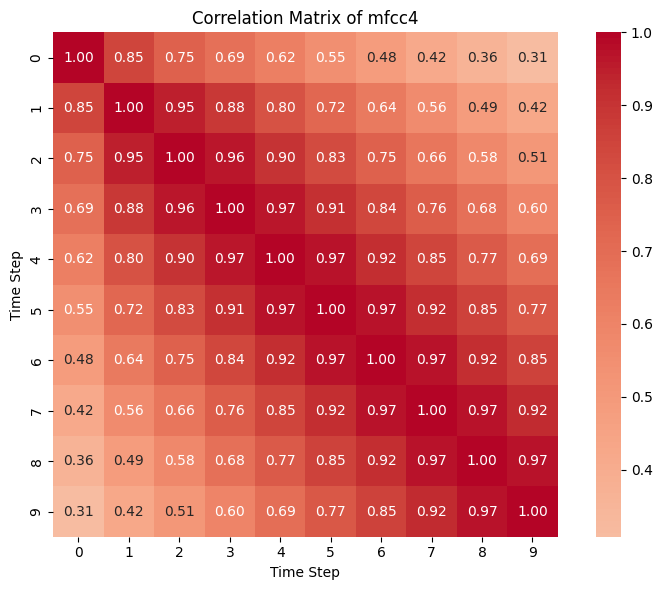

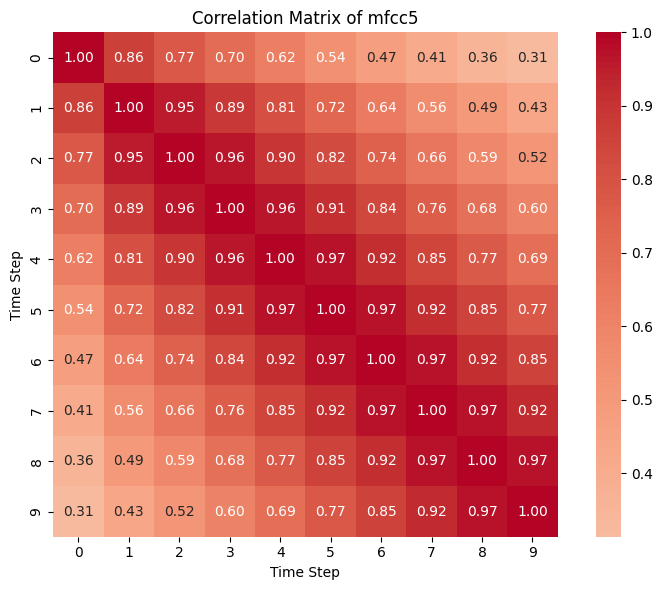

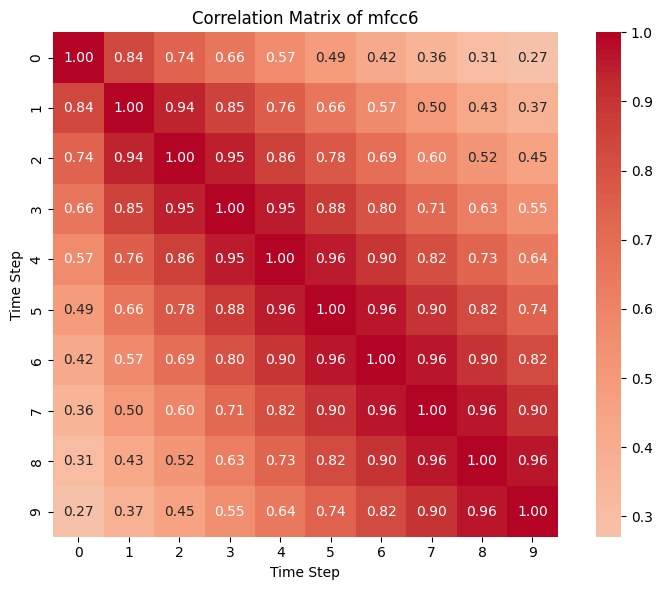

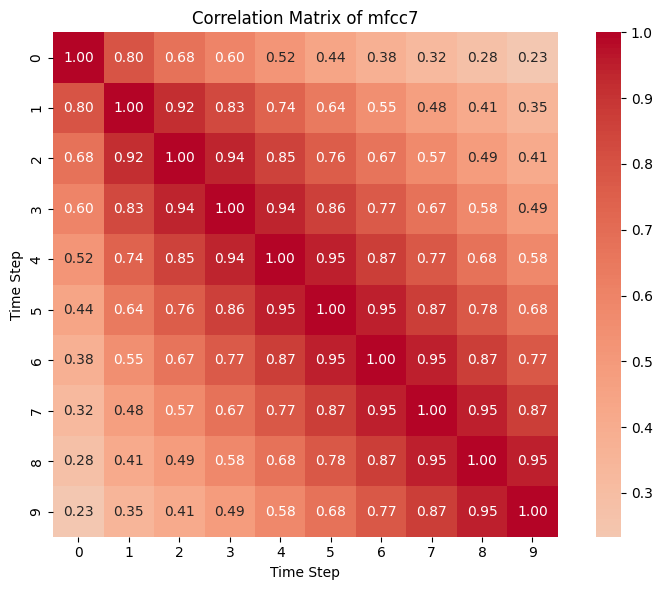

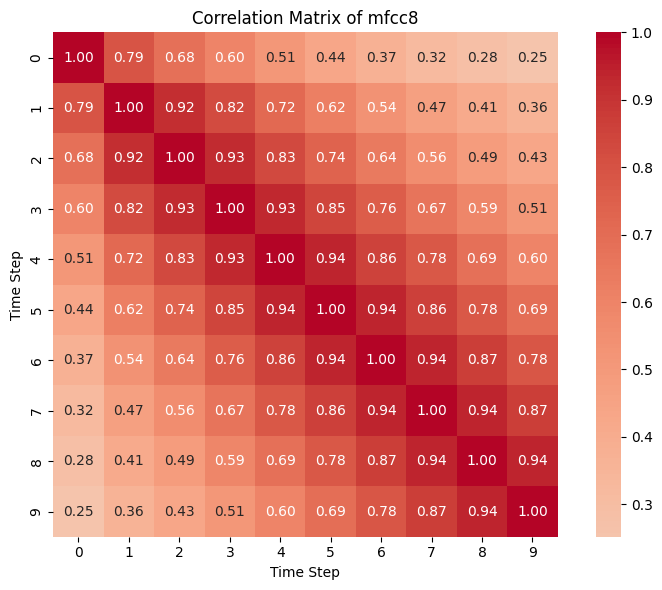

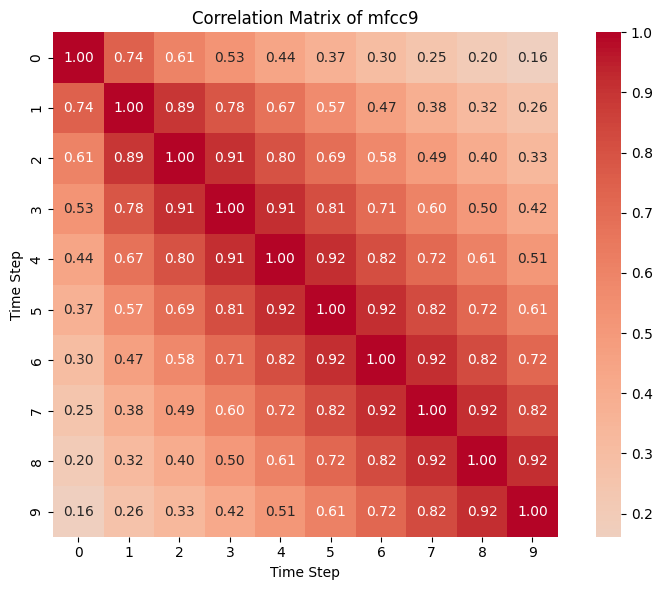

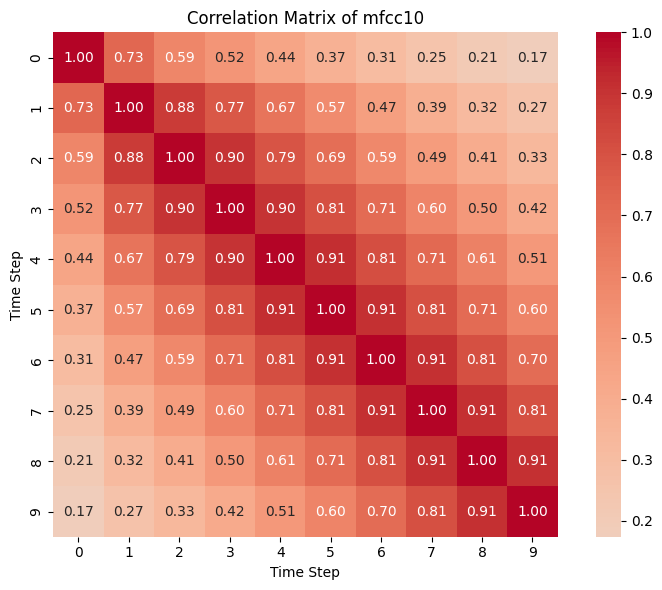

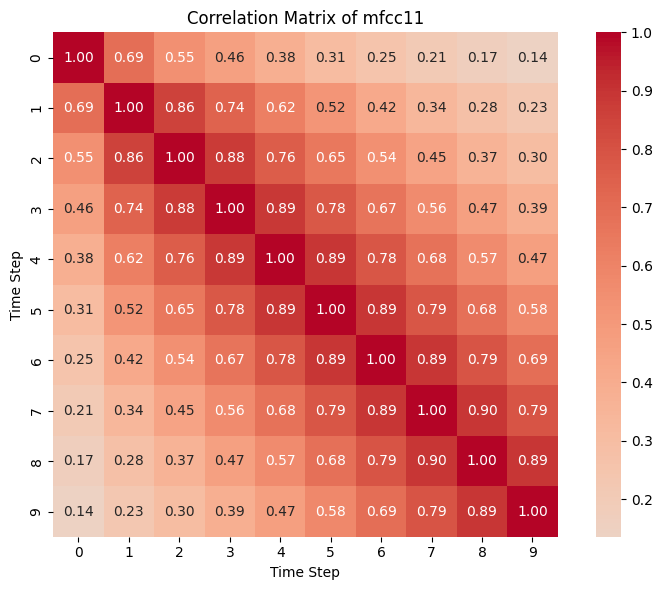

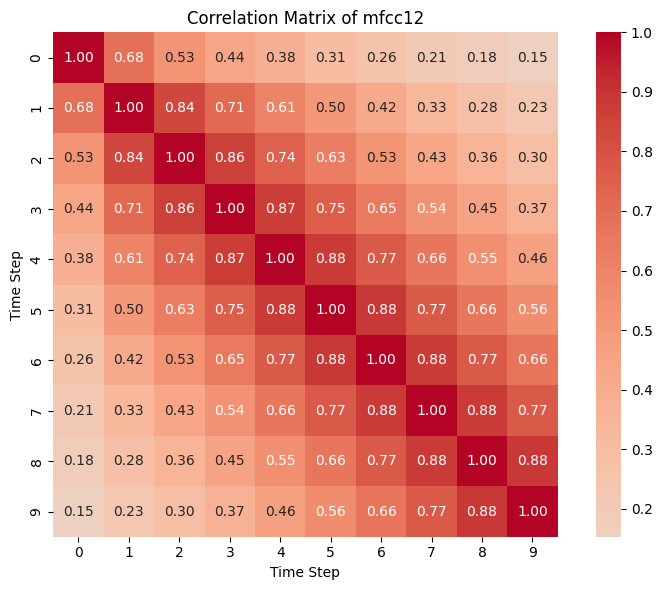

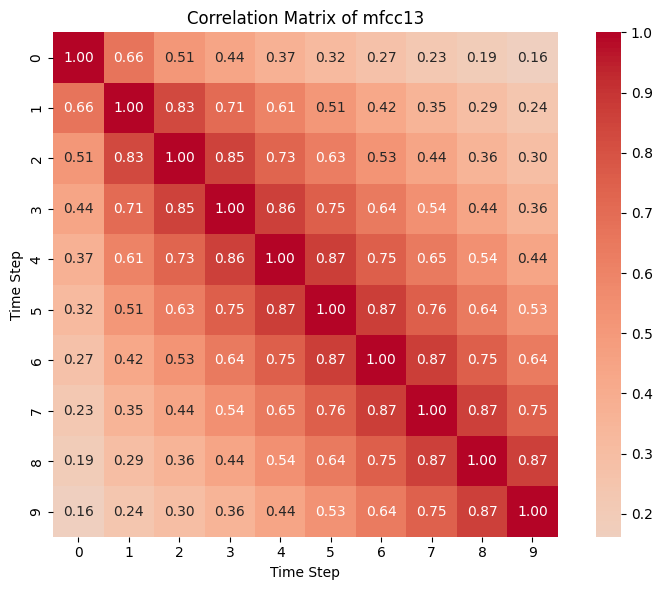

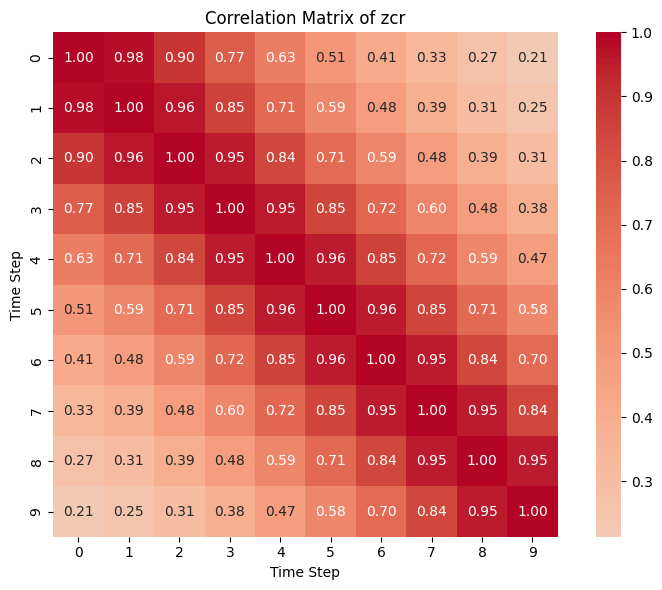

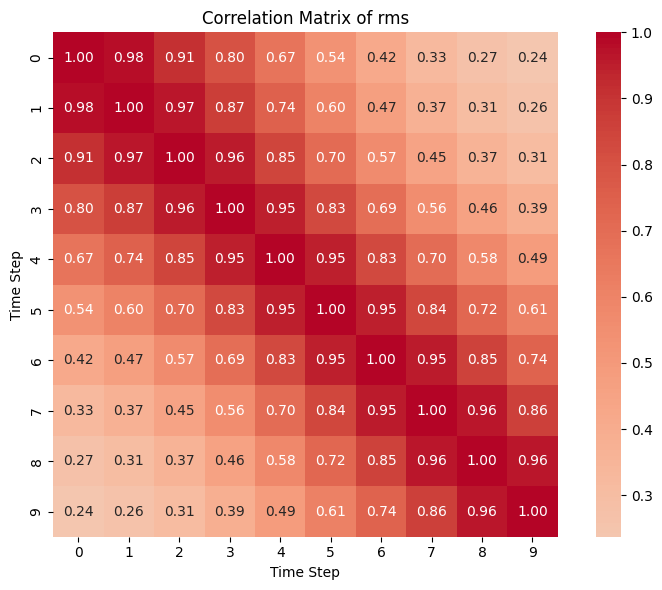

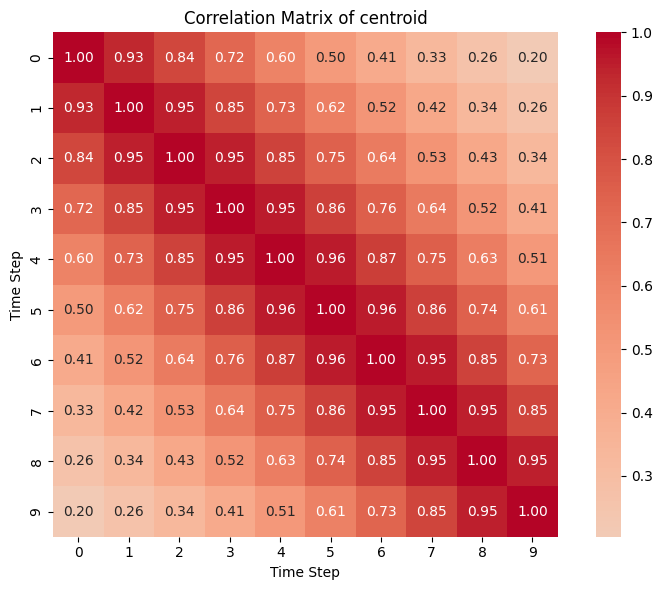

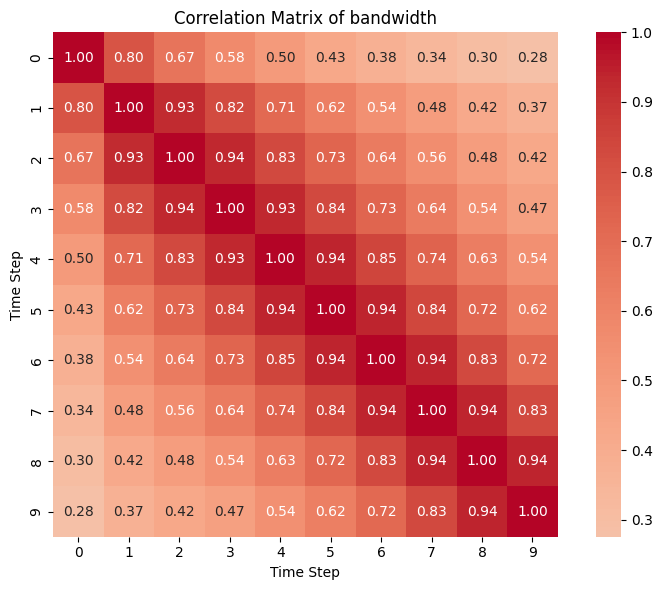

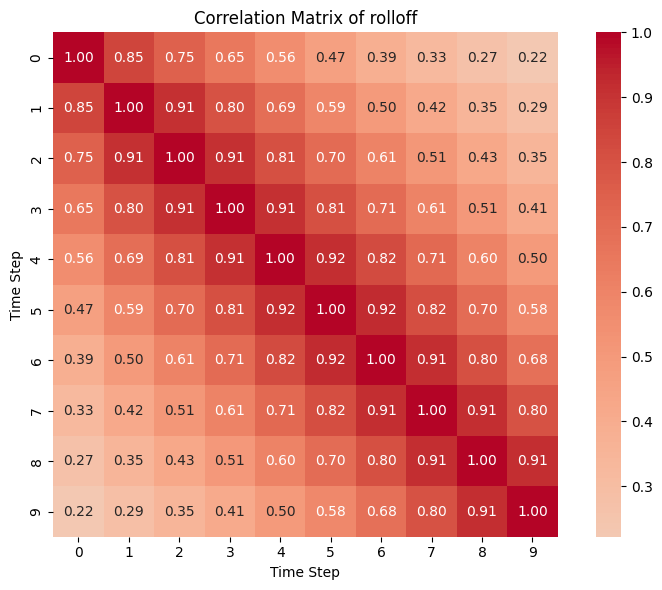

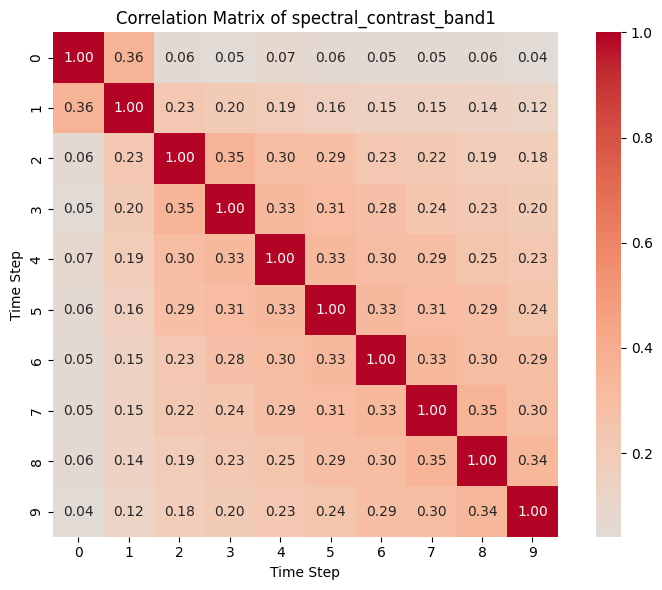

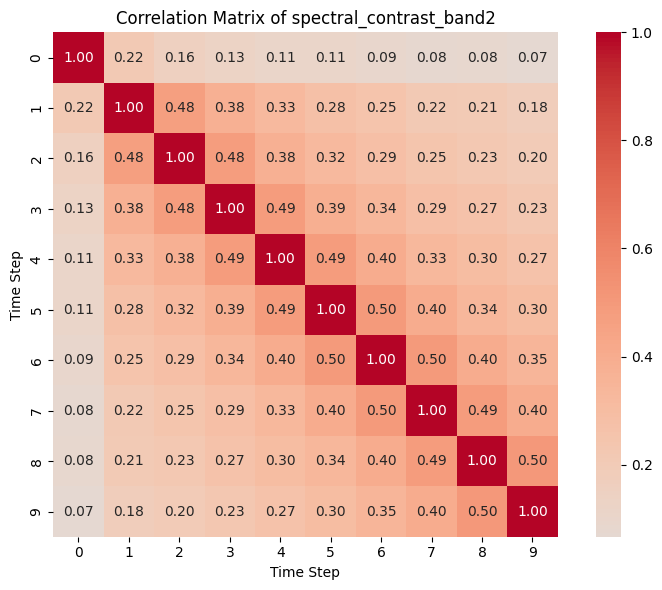

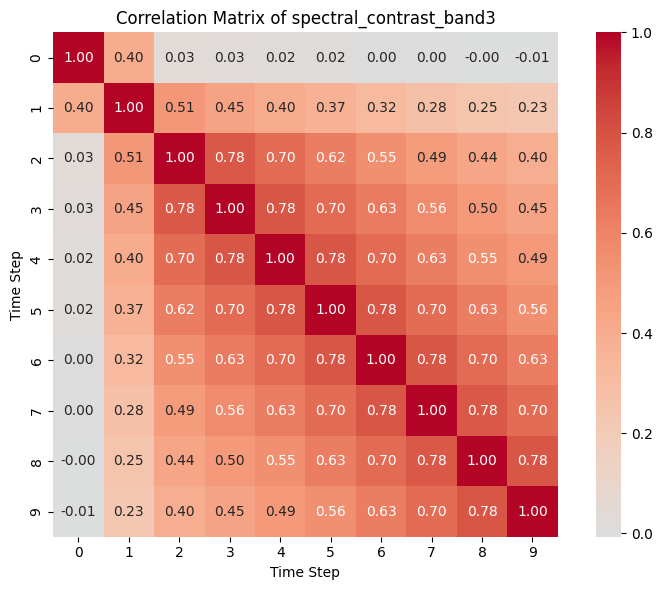

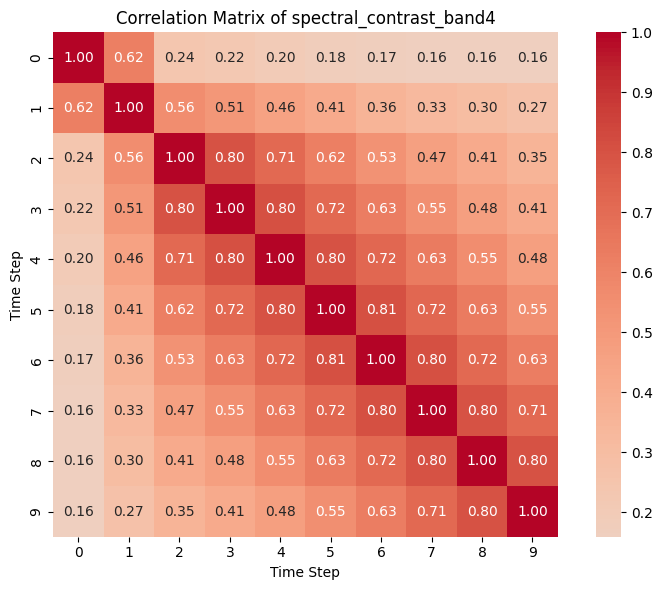

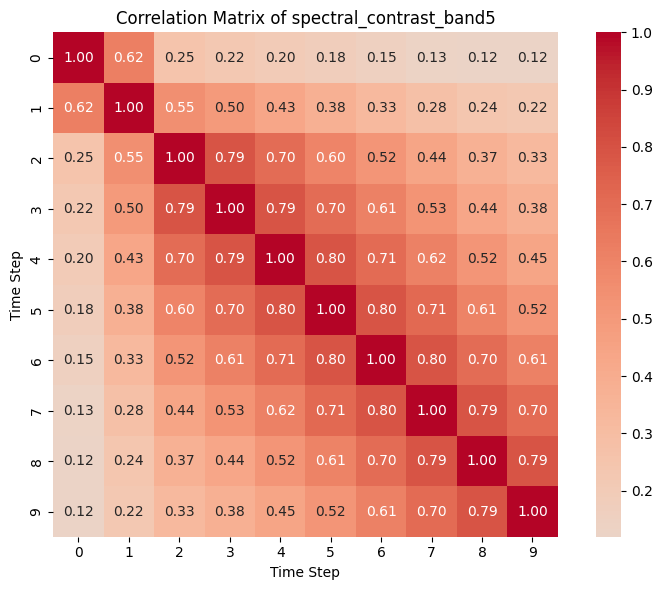

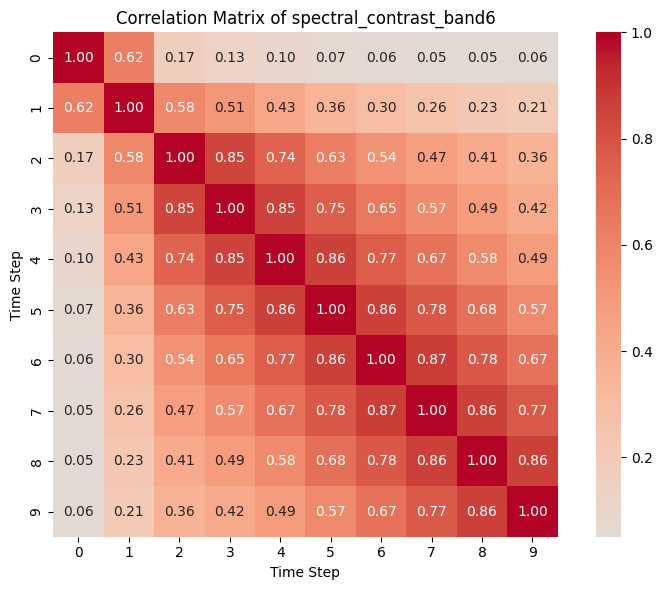

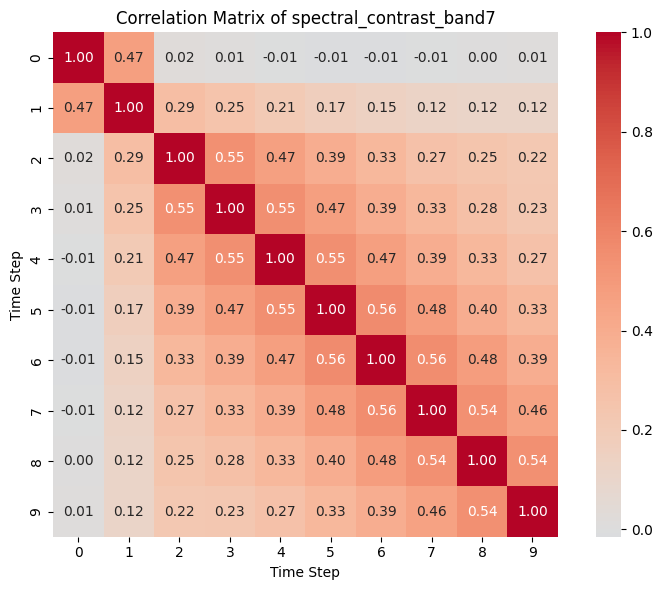

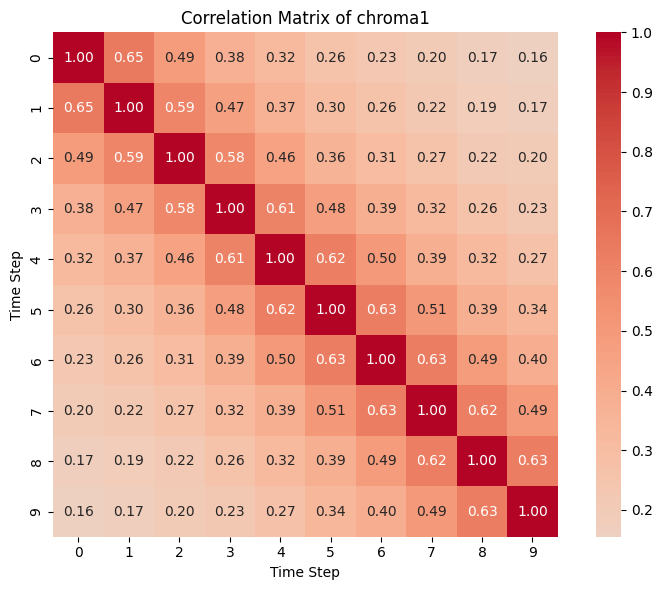

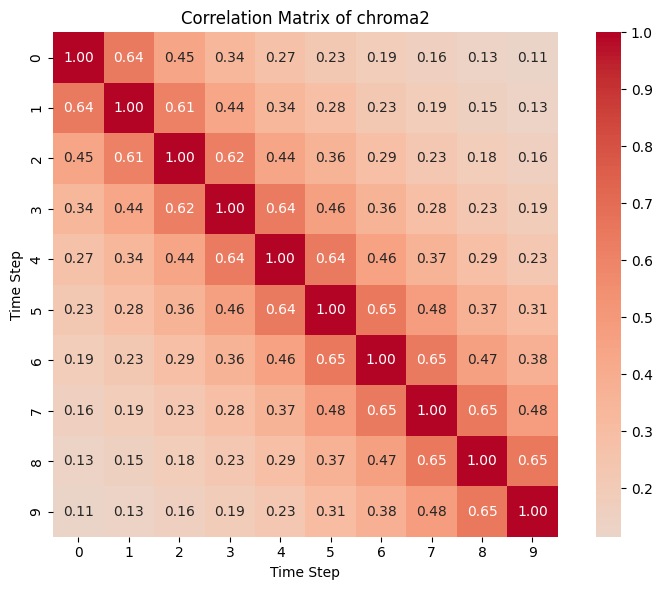

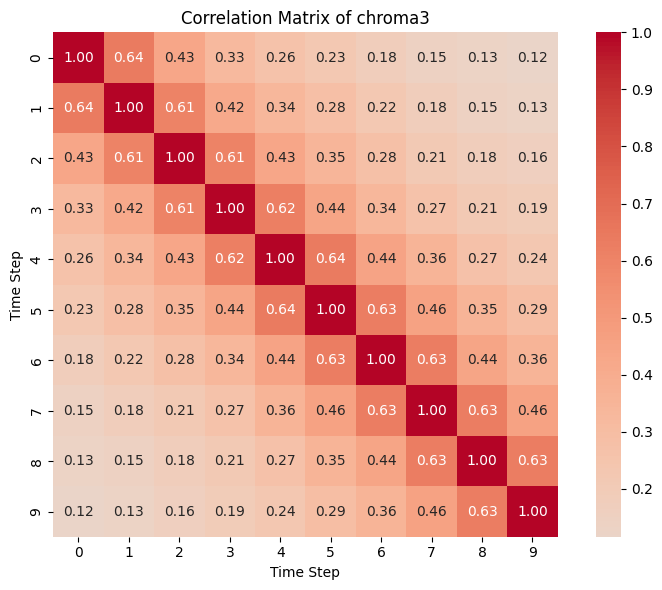

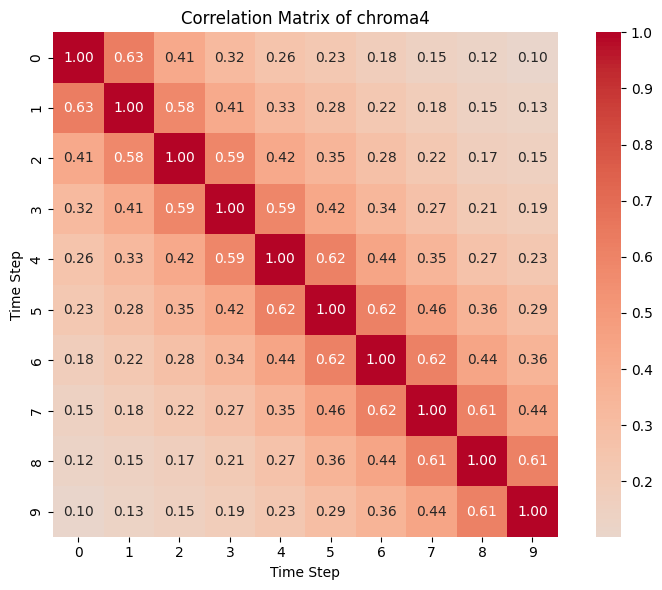

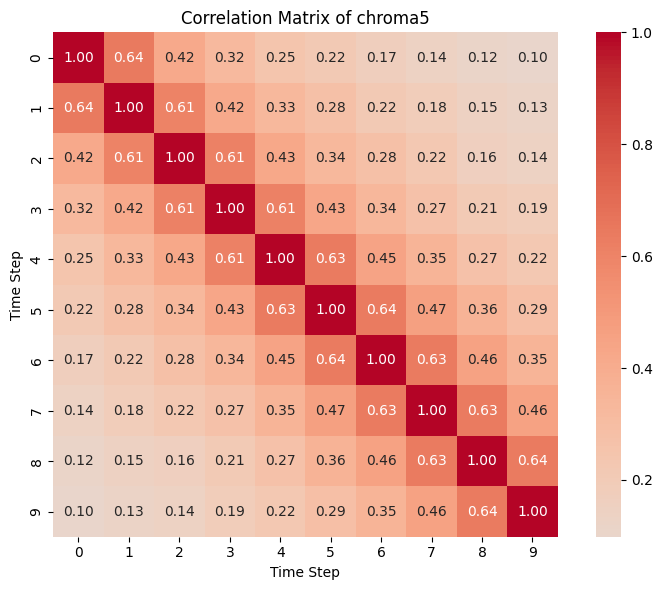

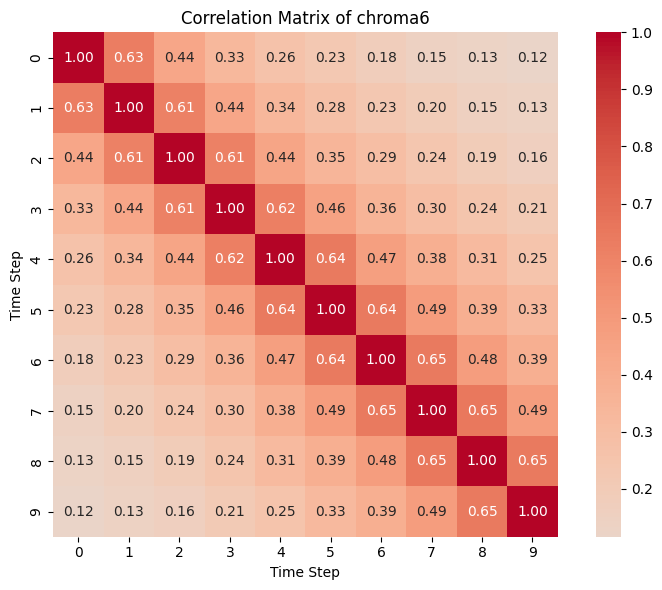

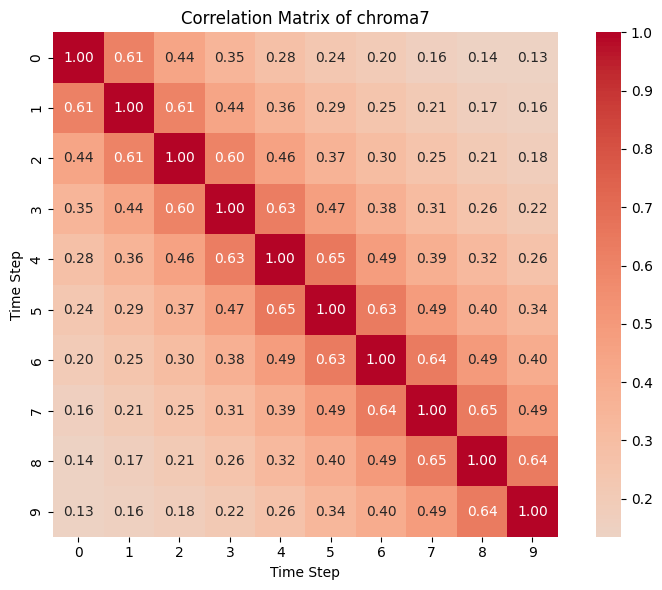

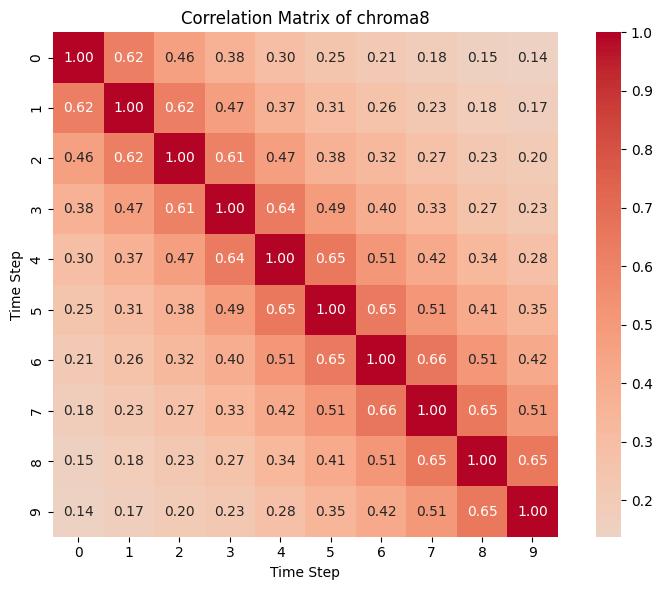

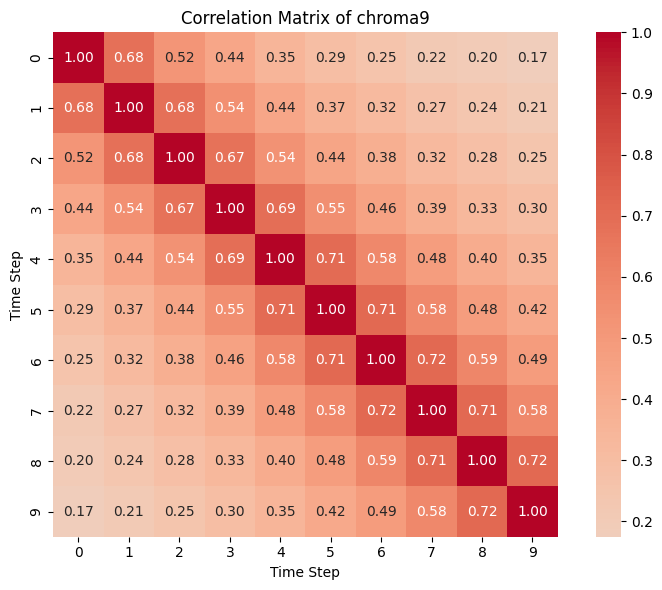

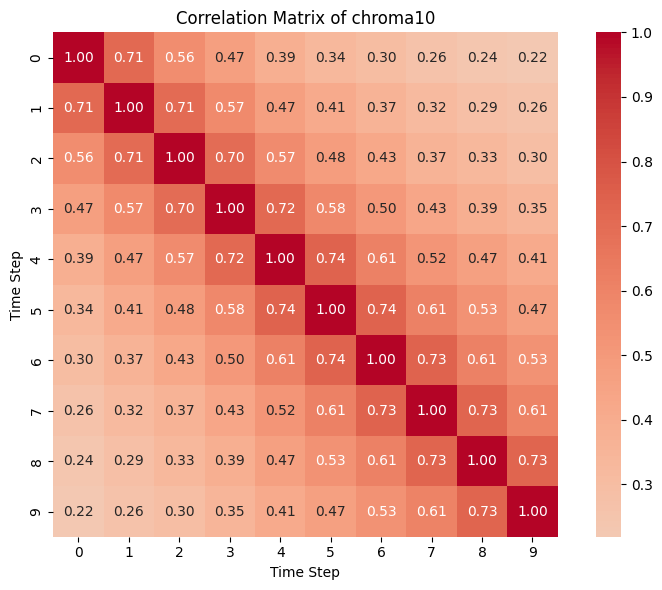

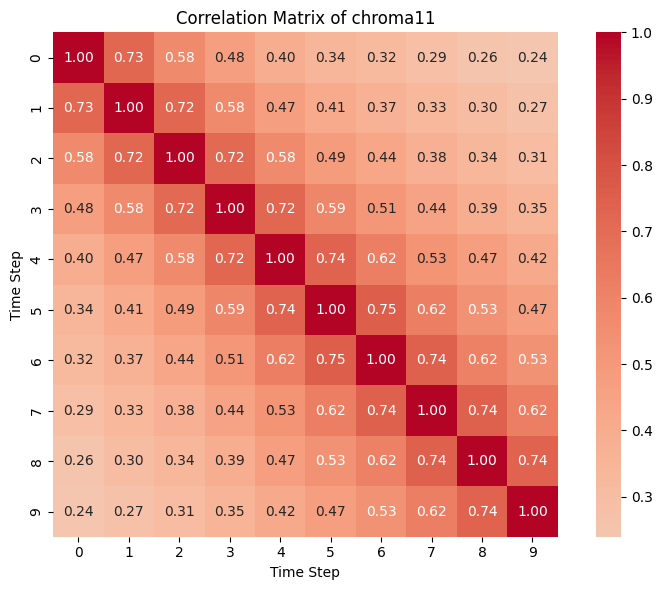

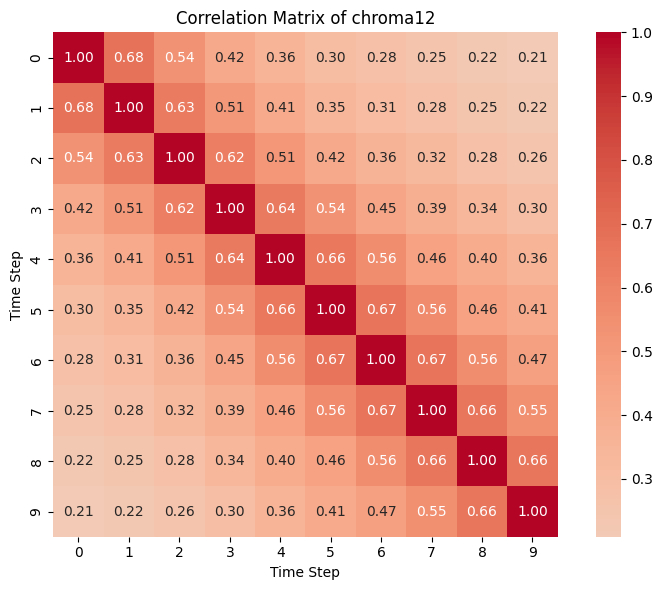

In [5]:
def plot_correlation_matrix(feature_name):
    feature_series = df[feature_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    X = np.stack(feature_series.values)

    X_first_10 = X[:, :10]
    corr_matrix = np.corrcoef(X_first_10.T)

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True, annot=True, fmt=".2f")
    plt.title(f"Correlation Matrix of {feature_name}")
    plt.xlabel("Time Step")
    plt.ylabel("Time Step")
    plt.tight_layout()
    plt.show()

# Run the analysis for each feature
for feature_name in all_feature_names:
    plot_correlation_matrix(feature_name)